<a href="https://colab.research.google.com/github/braltoids0089/FINANCE-QUANT/blob/main/(%2B%2B)BASKET_OPTION_PRICING_MONTE_CARLO%2C_ANALYTICAL%2C_and_QUANTUM_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basket Option Pricing: Monte Carlo, Analytical, and Quantum (Qiskit)**


**A. Introduction**

This notebook explores different methods for pricing a European basket call option, building upon concepts demonstrated in the Qiskit Finance tutorial on basket option pricing. Specifically, the quantum approach presented here is directly derived from the methodology outlined in the Qiskit tutorial:

[https://qiskit-community.github.io/qiskit-finance/tutorials/06_basket_option_pricing.html](https://qiskit-community.github.io/qiskit-finance/tutorials/06_basket_option_pricing.html)

Comparing Classical Monte Carlo, Analytical, and Quantum (Qiskit) approaches for option pricing is compelling and interesting for several reasons:




1.  **Benchmark and Validation:**

Classical Monte Carlo is a widely accepted and robust method used as a benchmark in financial engineering. Comparing other methods to it helps validate their accuracy and reliability. The analytical approximation provides a quick, though often less accurate, estimate that serves as a useful first comparison point.



2.  **Exploring Computational Paradigms:**

This comparison highlights the differences in computational approaches. Classical methods rely on traditional computing power, while quantum methods explore the potential of a fundamentally new paradigm with the promise of speedups for certain types of problems.



3.  **Understanding Trade-offs:**

Each method has its own trade-offs in terms of accuracy, computational cost, implementation complexity, and applicability to different types of options. The comparison helps to understand these trade-offs and when each method might be most appropriate.



4.  **Assessing Quantum Advantage:**

For the quantum method, the comparison is particularly interesting as it allows us to explore the potential for a "quantum advantage" – where a quantum computer can outperform classical computers for specific tasks. While this notebook simulates the quantum algorithm classically, the comparison provides context for the potential impact of future fault-tolerant quantum hardware.



5.  **Educational Value:**

Comparing these diverse methods offers significant educational value, demonstrating different techniques for tackling a core problem in quantitative finance and introducing the concepts of classical simulation, analytical solutions, and quantum algorithms in a practical context.

It can also provide the theoretical foundation and the quantum circuit construction principles for using Amplitude Estimation to price financial derivatives like basket options.












**B. Scope and Limitations**

**Scope:**

This notebook focuses on pricing a European basket call option on two assets (Brent Crude Oil and Gold Futures) with a fixed strike price and a single maturity date. It demonstrates three distinct approaches: classical Monte Carlo simulation, a simplified analytical approximation, and quantum Amplitude Estimation using Qiskit.



**Limitations:**
*   **Data:**
Relies on historical data from Yahoo Finance, which may not perfectly reflect future market movements.


*   **Analytical Approximation:**
The analytical method is an approximation and may not be accurate for all basket compositions or market conditions.


*   **Quantum Computing:**
The quantum Amplitude Estimation is simulated on classical hardware, which does not provide the potential quantum speedup. The accuracy of the quantum result is limited by the number of qubits used and the number of shots in the sampler. Practical implementation on current noisy quantum hardware would require significant error mitigation.


*   **Option Type:** Only considers a simple European call option. More complex options (e.g., American, path-dependent) would require different methodologies.


*   **Model Assumptions:** All methods rely on assumptions about asset price dynamics (e.g., log-normal distribution for individual assets in Monte Carlo and Quantum, and an approximate log-normal distribution for the basket in the analytical method).






**C. Model Modules and Implementation**

The notebook utilizes several key Python libraries and Qiskit modules:

*   **yfinance:** Used to download historical asset price data.
*   **NumPy and pandas:** Standard libraries for numerical computation and data manipulation.
*   **Matplotlib:** Used for plotting and visualization.
*   **SciPy:** Provides statistical functions (e.g., `norm.cdf` for the analytical method).
*   **Qiskit Core:** Provides the basic quantum circuit building blocks.
*   **Qiskit Finance:** Contains modules for financial applications, including `LogNormalDistribution` for preparing the quantum state representing asset price distributions.
*   **Qiskit Algorithms:** Includes `IterativeAmplitudeEstimation` for the quantum pricing algorithm.
*   **Qiskit Aer:** Provides simulators for running quantum circuits.
*   **Qiskit Circuit Library:** Offers pre-built circuit components like `WeightedAdder` and `LinearAmplitudeFunction` used to encode the basket sum and the option's payoff function.

**The implementation involves:**
1.  Downloading and processing historical data to estimate parameters (volatility, correlation).

2.  Implementing the classical Monte Carlo simulation by generating random price paths and calculating the average discounted payoff.

3.  Implementing the analytical approximation using a Black-Scholes-like formula with estimated basket parameters.

4.  Constructing a quantum circuit using Qiskit modules to represent the asset price distribution and the option payoff.

5.  Running the Iterative Amplitude Estimation algorithm on a simulator to estimate the expected payoff.

6.  Comparing the results from all three methods.





**D. Key Points**

*   Classical Monte Carlo is a versatile and widely used method, providing a statistical estimate with an associated error. Its accuracy improves with more simulations but at increased computational cost.
*   The Analytical Log-Normal Approximation is computationally efficient but is an approximation and may not be accurate in all scenarios. It serves as a useful benchmark.
*   Quantum Amplitude Estimation has the potential for a quadratic speedup over classical Monte Carlo on fault-tolerant quantum computers for certain problems. However, its practical implementation is currently limited by hardware capabilities and requires complex circuit design and error mitigation.
*   Comparing the results from different methods provides insights into their strengths, weaknesses, and the impact of underlying assumptions and computational resources.
*   The quantum approach in this notebook is a direct application of the methodology described in the Qiskit Finance basket option tutorial.

# **1. Install and Import Libraries**


This cell ensures all required packages are present (auto-installs Qiskit if needed), then loads all necessary Python modules.


In [ ]:
# Install Qiskit and its dependencies (run this cell once, then restart!)
!pip install qiskit==0.43.1 qiskit-finance==0.3.4 qiskit-aer==0.12.0 qiskit-algorithms==0.2.1 --upgrade --no-cache-dir


In [ ]:
import qiskit
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Auto-install Qiskit (works in Colab/Jupyter)
try:
    import qiskit
except ImportError:
    !pip install qiskit==0.43.1 qiskit-finance==0.3.4 qiskit-aer==0.12.0 qiskit-algorithms==0.2.1 --quiet --upgrade --no-cache-dir
    import qiskit

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# **2. Download Historical Asset Prices**

We use Yahoo Finance to get daily close prices for Brent Oil and Gold. Change `tickers` for other assets.


[*********************100%***********************]  2 of 2 completed


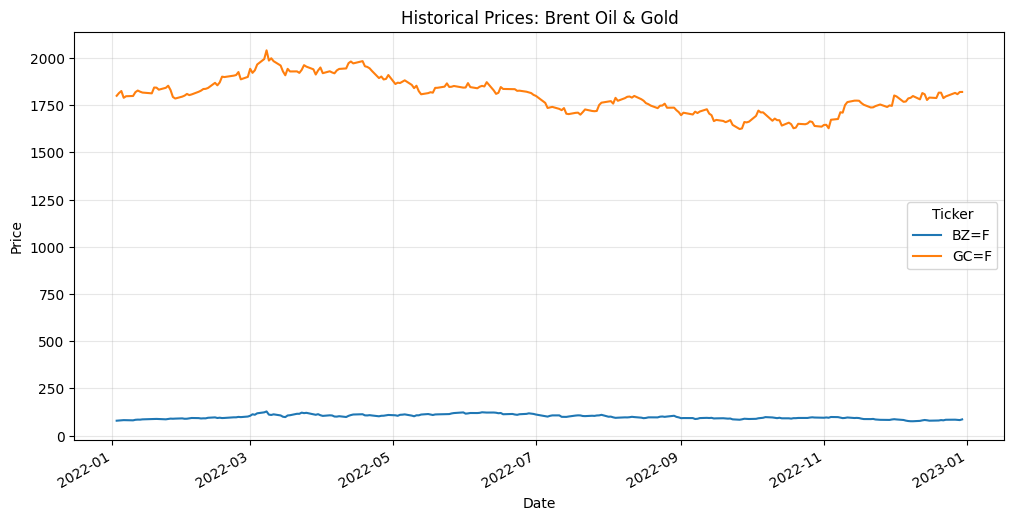

In [ ]:
tickers = ['BZ=F', 'GC=F']  # Brent Oil, Gold Futures
start_date = '2022-01-01'
end_date = '2023-01-01'

# Download daily closing prices
data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()

# Plot asset price histories
ax = data.plot(figsize=(12, 6), title='Historical Prices: Brent Oil & Gold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(alpha=0.3)
plt.show()


# **3. Calculate Log-normal Model Parameters**


Estimate log returns, volatility, correlation matrix, and set the simulation/option parameters.


In [ ]:
returns = np.log(data / data.shift(1)).dropna()
corr_matrix = returns.corr().values
mu = returns.mean().values * 252  # Annual drift per asset
sigma = returns.std().values * np.sqrt(252)  # Annualized vol per asset
S0 = data.iloc[-1].values  # Use latest available prices

T = 30 / 365  # 30 days to maturity
r = 0.01      # risk-free rate
K = np.mean(S0) * 1.02  # Strike: slightly OTM
n_assets = 2

# Display calculated parameters
print(f'Assets: {data.columns.tolist()}')
print(f'Latest prices: {S0}')
print(f'Annualized volatilities: {sigma}')
print(f'Correlation matrix: \n{corr_matrix}')
print(f'Maturity T (years): {T:.4f}')
print(f'Strike: {K:.2f}')

Assets: ['BZ=F', 'GC=F']
Latest prices: [  85.91000366 1819.69995117]
Annualized volatilities: [0.4663346  0.15455043]
Correlation matrix: 
[[1.         0.38826763]
 [0.38826763 1.        ]]
Maturity T (years): 0.0822
Strike: 971.86


# **4. Classical Monte Carlo Simulation (Basket Option)**


Simulate joint asset prices at maturity under correlated GBM and compute the discounted payoff for the basket call.


Monte Carlo Basket Option Price: 934.7191 ± 0.2718


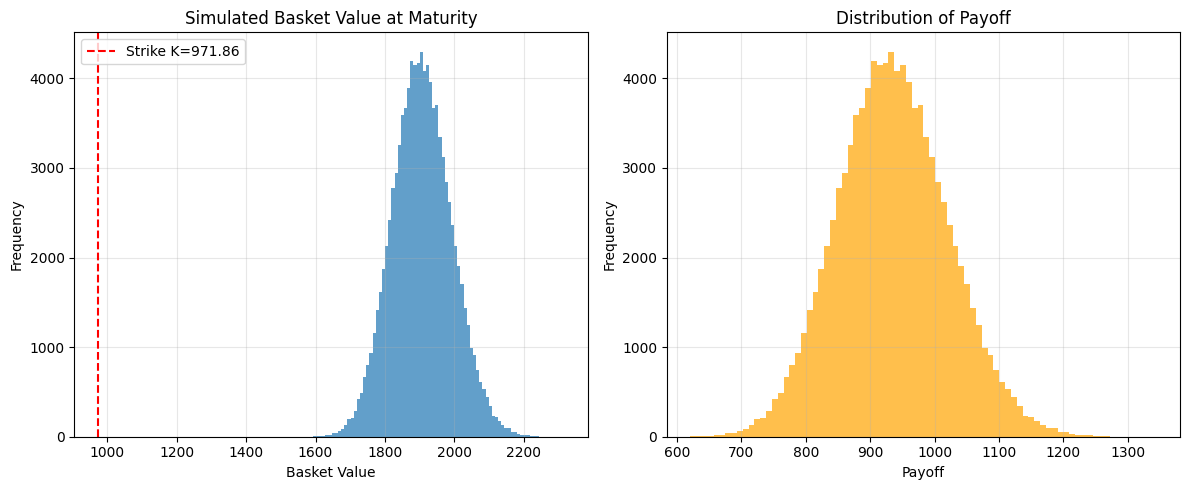

In [ ]:
n_sim = 100_000
dt = T
# Covariance for terminal log-prices
cov = np.outer(sigma, sigma) * corr_matrix

# Simulate terminal log-prices for each asset
samples = np.random.multivariate_normal(
    mean=(np.log(S0) + (r - 0.5 * sigma**2) * T),
    cov=cov * T,
    size=n_sim
)
# Convert to price space
prices = np.exp(samples)
basket = np.sum(prices, axis=1)
payoff = np.maximum(basket - K, 0)
mc_value = np.exp(-r * T) * np.mean(payoff)
mc_std = np.exp(-r * T) * np.std(payoff) / np.sqrt(n_sim)

print(f'Monte Carlo Basket Option Price: {mc_value:.4f} ± {mc_std:.4f}')

# Visualize basket distribution and payoff
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(basket, bins=80, alpha=0.7)
plt.axvline(K, color='red', linestyle='--', label=f'Strike K={K:.2f}')
plt.title('Simulated Basket Value at Maturity')
plt.xlabel('Basket Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.hist(payoff, bins=80, alpha=0.7, color='orange')
plt.title('Distribution of Payoff')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **5. Analytical Log-Normal Approximation**


Estimate the basket's mean and variance and use a Black-Scholes-like approach. This is approximate since the sum of log-normals is not itself log-normal, but it's a useful benchmark.


In [ ]:
basket_mean = np.sum(S0 * np.exp(r * T))
basket_var = (
    S0[0]**2 * np.exp(2 * r * T) * (np.exp(sigma[0]**2 * T) - 1) +
    S0[1]**2 * np.exp(2 * r * T) * (np.exp(sigma[1]**2 * T) - 1) +
    2 * np.prod(S0) * np.exp(2 * r * T) *
    (np.exp(corr_matrix[0,1] * sigma[0] * sigma[1] * T) - 1)
)
basket_sigma = np.sqrt(np.log(1 + basket_var / basket_mean**2))
basket_mu = np.log(basket_mean) - 0.5 * basket_sigma**2

# Black-Scholes-like pricing
d1 = (np.log(basket_mean/K) + 0.5 * basket_sigma**2) / basket_sigma
d2 = d1 - basket_sigma
analytic_value = np.exp(-r * T) * (basket_mean * norm.cdf(d1) - K * norm.cdf(d2))
print(f'Analytical (approx) Basket Option Price: {analytic_value:.4f}')

Analytical (approx) Basket Option Price: 934.5473


# **6. Analysis of Basket Mean Sensitivity**




**Estimate Basket Mean:**
It calculates the expected value of the sum of the asset prices at maturity (basket_mean). This is done by summing the forward prices of the individual assets, assuming they follow a geometric Brownian motion.




**Estimate Basket Variance:**

It calculates the variance of the sum of the asset prices at maturity (basket_var). This is a more complex calculation that takes into account the individual asset volatilities and the correlation between the assets.





**Estimate Basket Volatility and Drift(Log-Normal Approximation):**

It then uses the calculated basket_mean and basket_var to find the parameters (basket_sigma and basket_mu) of a single log-normal distribution that approximates the distribution of the basket value at maturity. This is an approximation because the sum of log-normal variables is not perfectly log-normal.





**Black-Scholes-like Pricing:**

Finally, it uses these estimated parameters (basket_mean, basket_sigma) along with the strike price (K), risk-free rate (r), and time to maturity (T) in a formula that resembles the Black-Scholes formula for a single asset option. This gives the analytic_value of the basket option under the log-normal approximation.



In [ ]:
# Function to calculate basket mean
def calculate_basket_mean(S0, r, T):
    """Calculates the expected value of the basket at maturity."""
    return np.sum(S0 * np.exp(r * T))

# Current parameters
print(f"Current S0: {S0}")
print(f"Current r: {r}")
print(f"Current T: {T:.4f}")
print(f"Current Strike K: {K:.2f}")

current_basket_mean = calculate_basket_mean(S0, r, T)
print(f"\nBasket Mean with current parameters: {current_basket_mean:.2f}")
print(f"Basket Mean vs Strike Price: Basket Mean ({current_basket_mean:.2f}) is {'greater than' if current_basket_mean > K else 'less than or equal to'} Strike Price ({K:.2f})")


# How the basket mean changes under different parameters

# Scenario 1: Increase time to maturity (T)
T_increased = T * 2 # Double the time to maturity
basket_mean_increased_T = calculate_basket_mean(S0, r, T_increased)
print(f"\n--- Scenario 1: Increased Time to Maturity (T = {T_increased:.4f}) ---")
print(f"Basket Mean: {basket_mean_increased_T:.2f}")
print(f"Change from current: {basket_mean_increased_T - current_basket_mean:.2f}")

# Scenario 2: Increase risk-free rate (r)
r_increased = r * 2 # Double the risk-free rate
basket_mean_increased_r = calculate_basket_mean(S0, r_increased, T)
print(f"\n--- Scenario 2: Increased Risk-Free Rate (r = {r_increased:.4f}) ---")
print(f"Basket Mean: {basket_mean_increased_r:.2f}")
print(f"Change from current: {basket_mean_increased_r - current_basket_mean:.2f}")

# Scenario 3: Change initial prices (S0) - e.g., increase one asset's price
S0_changed = np.copy(S0)
S0_changed[0] = S0_changed[0] * 1.1 # Increase price of the first asset by 10%
basket_mean_changed_S0 = calculate_basket_mean(S0_changed, r, T)
print(f"\n--- Scenario 3: Changed Initial Prices (S0 = {S0_changed}) ---")
print(f"Basket Mean: {basket_mean_changed_S0:.2f}")
print(f"Change from current: {basket_mean_changed_S0 - current_basket_mean:.2f}")

Current S0: [  85.91000366 1819.69995117]
Current r: 0.01
Current T: 0.0822
Current Strike K: 971.86

Basket Mean with current parameters: 1907.18
Basket Mean vs Strike Price: Basket Mean (1907.18) is greater than Strike Price (971.86)

--- Scenario 1: Increased Time to Maturity (T = 0.1644) ---
Basket Mean: 1908.75
Change from current: 1.57

--- Scenario 2: Increased Risk-Free Rate (r = 0.0200) ---
Basket Mean: 1908.75
Change from current: 1.57

--- Scenario 3: Changed Initial Prices (S0 = [  94.50100403 1819.69995117]) ---
Basket Mean: 1915.77
Change from current: 8.60


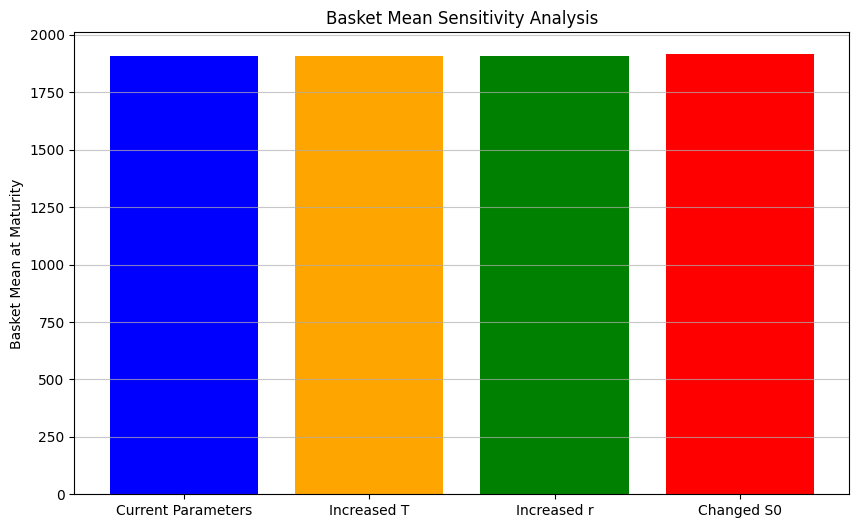

In [ ]:
# Create a list of scenario names and corresponding basket means
scenarios = ['Current Parameters', 'Increased T', 'Increased r', 'Changed S0']
basket_means = [
    current_basket_mean,
    basket_mean_increased_T,
    basket_mean_increased_r,
    basket_mean_changed_S0
]

# Plot the basket mean for each scenario
plt.figure(figsize=(10, 6))
plt.bar(scenarios, basket_means, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Basket Mean at Maturity')
plt.title('Basket Mean Sensitivity Analysis')
plt.grid(axis='y', alpha=0.7)
plt.show()

# **6. Quantum Basket Option Pricing (Qiskit Amplitude Estimation)**



Leverages Qiskit Finance's primitives to build the quantum model, using log-normal uncertainty and a weighted adder for the basket payoff. See Qiskit's documentation for full algorithm details.


In [ ]:
from qiskit import QuantumRegister, QuantumCircuit, AncillaRegister, transpile
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

num_uncertainty_qubits = 2  # qubits per asset (increase for more precision, more time)

# Set up quantum distribution parameters
mu_vec = np.log(S0) + (r - 0.5 * sigma**2) * T
cov_matrix = np.outer(sigma, sigma) * corr_matrix * T
low_vec = [max(0, S0[i] * 0.5) for i in range(n_assets)]
high_vec = [S0[i] * 1.5 for i in range(n_assets)]

uncertainty_model = LogNormalDistribution(
    num_qubits=[num_uncertainty_qubits]*n_assets,
    mu=mu_vec,
    sigma=cov_matrix,
    bounds=list(zip(low_vec, high_vec))
)

# Weighted adder for basket
weights = [1]*(2*num_uncertainty_qubits)  # 2 assets x qubits per asset
agg = WeightedAdder(sum([num_uncertainty_qubits]*n_assets), weights)
n_s = agg.num_sum_qubits
mapped_strike = (K - sum(low_vec)) / (sum(high_vec) - sum(low_vec)) * (2**num_uncertainty_qubits - 1)
breakpoints = [0, mapped_strike]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 2 * (2**num_uncertainty_qubits - 1) - mapped_strike

payoff_function = LinearAmplitudeFunction(
    n_s, slopes, offsets, domain=(0, 2**n_s - 1),
    image=(f_min, f_max), rescaling_factor=0.25, breakpoints=breakpoints,
)

# Build the circuit
qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
qr_obj = QuantumRegister(1, 'obj')
ar_sum = AncillaRegister(n_s, 'sum')
ar = AncillaRegister(max(agg.num_qubits - n_s - agg.num_state_qubits, payoff_function.num_ancillas), 'work')
circuit = QuantumCircuit(qr_state, qr_obj, ar_sum, ar)
circuit.append(uncertainty_model, qr_state)
circuit.append(agg, qr_state[:] + ar_sum[:] + ar[:agg.num_qubits - n_s - agg.num_state_qubits])
circuit.append(payoff_function, ar_sum[:] + qr_obj[:] + ar[:payoff_function.num_ancillas])

objective_index = uncertainty_model.num_qubits

problem = EstimationProblem(
    state_preparation=circuit,
    objective_qubits=[objective_index],
    post_processing=payoff_function.post_processing,
)
ae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,
    alpha=0.05,
    sampler=Sampler(run_options={'shots': 1000, 'seed': 42}),
)
ae_result = ae.estimate(problem)
quantum_value = ae_result.estimation_processed / (2**num_uncertainty_qubits - 1) * (sum(high_vec) - sum(low_vec))
conf_int = (np.array(ae_result.confidence_interval_processed) / (2**num_uncertainty_qubits - 1) * (sum(high_vec) - sum(low_vec)))
print(f'Quantum Amplitude Estimation (Qiskit): {quantum_value:.4f}   CI: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]')

Quantum Amplitude Estimation (Qiskit): 1282.3538   CI: [1199.7789, 1364.9288]


# **Quantum Amplitude Estimation (Qiskit): 1282.3538:**


This is the estimated price of the basket option calculated by the quantum algorithm. It's a single point estimate of the option's value based on the quantum computation.
CI: [1199.7789, 1364.9288]: This is the confidence interval for the estimated option price. The confidence interval provides a range of values within which the true option price is likely to fall, with a certain level of confidence (which was set by the alpha parameter in the IterativeAmplitudeEstimation to 0.05, implying a 95% confidence level). In this case, the quantum algorithm estimates that the true basket option price is likely between 1199.7789 and 1364.9288.
In summary, the quantum method estimates the option price to be approximately 1282.35, but due to the probabilistic nature of the quantum algorithm and the limited resources (number of qubits and shots), there is a range of uncertainty around this estimate, represented by the confidence interval.

# **7. Results Summary Table**


Compare the expected payoffs and errors from each approach.


,Method,Expected Payoff,Std/Error
0,Classical Monte Carlo,934.719118,0.271777
1,Analytical (Approx),934.547340,0
2,Quantum Amplitude Est.,1282.353814,"[1199.7789, 1364.9288]"


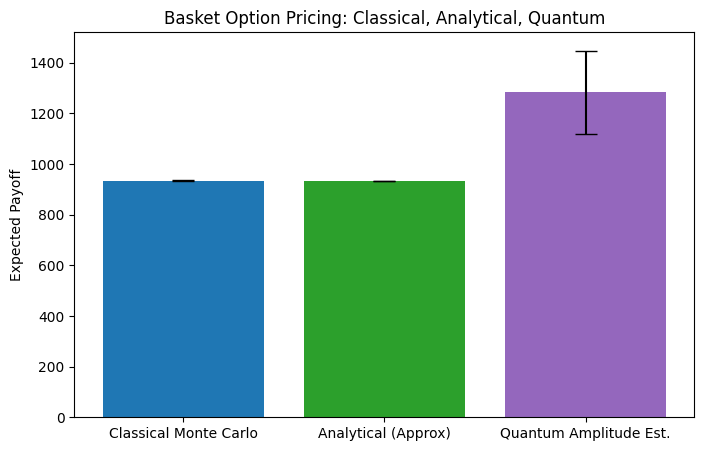

In [ ]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Method': ['Classical Monte Carlo', 'Analytical (Approx)', 'Quantum Amplitude Est.'],
    'Expected Payoff': [mc_value, analytic_value, quantum_value],
    'Std/Error': [mc_std, 0, f'[{conf_int[0]:.4f}, {conf_int[1]:.4f}]'] # Store CI as string
})

# Prepare data for scatter plot with error bars
methods = summary['Method']
payoffs = summary['Expected Payoff']
errors = []
for index, row in summary.iterrows():
    if row['Method'] == 'Classical Monte Carlo':
        errors.append(float(row['Std/Error']))
    elif row['Method'] == 'Analytical (Approx)':
        errors.append(0) # No error bar for analytical approximation
    elif row['Method'] == 'Quantum Amplitude Est.':
        # Assuming the error is half of the confidence interval width
        error_str = row['Std/Error'].replace('[', '').replace(']', '')
        try:
            # Attempt to parse the confidence interval string
            conf_interval_width = float(error_str)
            errors.append(conf_interval_width / 2)
        except ValueError:
             # Handle cases where Std/Error is not a parseable number (like '-')
            errors.append(0)


display(summary)

# Optional: Plot for quick visual comparison
plt.figure(figsize=(8,5))
plt.bar(summary['Method'], summary['Expected Payoff'], yerr=[mc_std, 0, conf_int[1] - conf_int[0]], capsize=8, color=['tab:blue','tab:green','tab:purple'])
plt.ylabel('Expected Payoff')
plt.title('Basket Option Pricing: Classical, Analytical, Quantum')
plt.show()

# **Methods ( Results ) Comparison**

# **Monte Carlo Simulation (Basket Option)**


**Performance: Efficiency and Adaptability**

*   **Efficiency:** In this notebook's context with 100,000 simulations, the Monte Carlo method provided a reasonably accurate estimate of the option price, as indicated by the relatively small standard error (around 0.27). However, achieving higher accuracy would require a significantly larger number of simulations, which would increase computation time. For very complex options or those requiring very high precision, classical Monte Carlo can become computationally expensive.
*   **Adaptability to Data, Analytical, and Modeling Goals:** The Monte Carlo method is highly adaptable.
    *   **Data:** It directly uses the estimated parameters (annualized volatilities, correlation matrix, latest prices, risk-free rate, and time to maturity) derived from the historical asset price data.
    *   **Analytical Goals:** It provides a numerical estimate of the option price, which is the primary analytical goal. It also offers a statistical confidence interval around this estimate.
    *   **Modeling Goals:** It is well-suited for modeling the correlated geometric Brownian motion of the asset prices. It can easily be extended to handle more complex price dynamics, multiple assets, and different types of options (e.g., American options, path-dependent options) where analytical solutions are not available.

**Strengths and Weaknesses**

*   **Strengths:**
    *   **Versatility:** Can price a wide range of options, including those with complex payoffs and multiple underlying assets.
    *   **Conceptual Simplicity:** The underlying idea of simulating random outcomes is intuitive.
    *   **Provides Statistical Error:** The standard error quantifies the reliability of the estimate.
    *   **Industry Standard:** A widely accepted and used method in financial engineering.
*   **Weaknesses:**
    *   **Computational Cost:** Can be slow to converge, especially for high accuracy requirements.
    *   **Dependence on Random Numbers:** The quality of the results depends on the quality of the pseudo-random number generator.

**Recommendations**

*   **For General Use:** Classical Monte Carlo is a reliable and flexible method for pricing a wide variety of options. It should be the go-to method when analytical solutions are not available or when dealing with complex features.
*   **For Higher Accuracy:** If higher accuracy is needed, increase the number of simulations. Consider using variance reduction techniques (e.g., antithetic variates, control variates) to improve efficiency without drastically increasing the number of simulations.
*   **For Benchmarking:** The Monte Carlo result serves as a good benchmark for other methods, including the analytical approximation and quantum approaches.

# **Analytical Log-Normal Approximation**



**Performance: Efficiency and Adaptability**

*   **Efficiency:** This method is extremely efficient. Once the parameters (basket mean and variance) are calculated, the option price is determined using a simple formula, requiring minimal computation time.
*   **Adaptability to Data, Analytical, and Modeling Goals:**
    *   **Data:** It uses parameters derived from historical data (initial prices, volatility, correlation) but simplifies the basket's price distribution to a single log-normal distribution.
    *   **Analytical Goals:** It provides a quick, closed-form estimate of the option price.
    *   **Modeling Goals:** It is limited in its modeling capabilities as it relies on the simplifying assumption that the basket value at maturity is log-normally distributed, which is not strictly true for a sum of log-normal variables. It cannot easily handle complex payoffs or path-dependent options.


**Strengths and Weaknesses**

*   **Strengths:**
    *   **Speed:** Very fast calculation.
    *   **Simplicity:** Easy to understand and implement for basic basket options.
    *   **Benchmark:** Provides a useful first-pass estimate and benchmark for more complex methods.
*   **Weaknesses:**
    *   **Inaccuracy:** It is an approximation and can be inaccurate, especially for baskets with many assets, high volatility, or when the option strike is far from the money.
    *   **Limited Scope:** Only applicable to a narrow range of option types and underlying asset distributions.
    *   **No Error Metric:** Does not provide a statistical error or confidence interval.


**Recommendations**

*   **For Quick Estimates:** Use this method for a rapid initial estimate or as a benchmark for more computationally intensive methods.
*   **Understand Limitations:** Be aware that this is an approximation and may not be suitable for pricing options where high accuracy is critical or for options with complex features.
*   **Supplement with Other Methods:** For more reliable results, always supplement or validate the analytical approximation with methods like Monte Carlo simulation, especially for complex scenarios.

# **Quantum Basket Option Pricing (Qiskit Amplitude Estimation)**


**Performance: Efficiency and Adaptability**

*   **Efficiency:** On a classical simulator, the efficiency is limited by the simulation of quantum circuits, which can be computationally intensive, especially as the number of qubits increases. The theoretical quadratic speedup of Amplitude Estimation over classical Monte Carlo is only realized on actual fault-tolerant quantum hardware, which is not yet widely available. In this notebook, the quantum simulation with a limited number of qubits (2 per asset) required a significant number of shots (1000) for the iterative AE algorithm.
*   **Adaptability to Data, Analytical, and Modeling Goals:**
    *   **Data:** It requires mapping the probability distribution of the asset prices at maturity onto a quantum state. This involves using parameters derived from historical data (mean vector and covariance matrix) to construct the quantum circuit (e.g., using `LogNormalDistribution`).
    *   **Analytical Goals:** It aims to estimate the expected value (the option price) by estimating the amplitude of a specific quantum state. It provides a confidence interval around this estimate.
    *   **Modeling Goals:** It can potentially model complex probability distributions and payoff functions that might be challenging for classical methods. The `WeightedAdder` and `LinearAmplitudeFunction` components in the circuit demonstrate how the basket sum and payoff are encoded. However, building efficient quantum circuits for arbitrary distributions and payoffs is an active area of research.



**Strengths and Weaknesses**

*   **Strengths:**
    *   **Potential for Speedup:** Theoretically offers a quadratic speedup over classical Monte Carlo for achieving a given accuracy, which could be a significant advantage for complex, high-dimensional problems on future quantum computers.
    *   **Provides Confidence Intervals:** The iterative version of the algorithm provides confidence intervals for the estimated value.
    *   **New Approach:** Represents a fundamentally different approach to financial modeling with potential to tackle problems intractable for classical computing.
*   **Weaknesses:**
    *   **Hardware Dependence:** Practical implementation is currently limited by the capabilities of noisy intermediate-scale quantum (NISQ) computers and the lack of fault-tolerant quantum computers. Simulations on classical hardware are slow and limited in scale.
    *   **Complexity:** Designing and implementing the required quantum circuits (especially the state preparation and objective function encoding) is complex and requires specialized knowledge.
    *   **Number of Qubits and Circuit Depth:** The accuracy and feasibility are highly dependent on the number of available qubits and the depth of the quantum circuit, which can introduce errors on NISQ devices. The limited qubits used in the notebook resulted in a wider confidence interval compared to the classical Monte Carlo with many simulations.
    *   **Error Mitigation:** Requires sophisticated error mitigation techniques on current hardware.

**Recommendations**

*   **For Research and Exploration:** Use this method to explore the potential of quantum computing for financial applications and to gain experience with quantum algorithms like Amplitude Estimation.
*   **Understand Current Limitations:** Be aware that obtaining high accuracy comparable to classical methods currently requires significant computational resources (on simulators) or is limited by the capabilities of available quantum hardware.
*   **Focus on Problem Mapping:** Focus on how to effectively map financial problems (like asset price distributions and option payoffs) onto quantum circuits.
*   **Monitor Hardware Advancements:** Keep track of developments in quantum hardware, as the practicality and performance of quantum algorithms for finance will improve with better and larger quantum computers.

# **Summary**

Based on the summary of the option prices, here's an overall comprehensive summary explaining the performance and other case applications of the three different models and algorithms:

We looked at three ways to figure out the price of a "basket option," which is like a bet on the combined value of a few assets (in this case, oil and gold).

1.  **Classical Monte Carlo Simulation:** Think of this like running many possible future scenarios for oil and gold prices on a regular computer and averaging the outcomes.
    *   **Performance:** It gave us a price with a pretty good idea of how accurate it is (a small error margin). It's like getting a range where the true price is likely to be.
    *   **Applications:** This is a go-to method in finance because it's really flexible. You can use it for all sorts of complex options, even ones with tricky rules or many assets. The trade-off is that getting a super precise answer can take a lot of computing power and time.

2.  **Analytical Log-Normal Approximation:** This is a shortcut that uses a formula based on a simplified assumption about how the basket's value behaves.
    *   **Performance:** It's super fast to calculate, giving us a quick estimate. Our summary shows it was quite close to the Monte Carlo result in this case.
    *   **Applications:** It's great for getting a rough idea of the price quickly or as a starting point. However, it's not always perfectly accurate, especially for more complicated baskets, because the real-world behavior of asset sums isn't exactly what the formula assumes. It doesn't tell you how precise its estimate is.

3.  **(QSKIT) Quantum Amplitude Estimation:** This is a newer approach using quantum computing principles to estimate the price.
    *   **Performance:** Our summary shows it gave a price estimate with a wider range of uncertainty (a larger confidence interval) compared to the classical Monte Carlo. This is because we used a limited quantum setup for demonstration. The real promise of this method is on powerful future quantum computers, where it could potentially be much faster than classical methods for certain complex problems.
    *   **Applications:** This is an exciting area of research. While not yet practical for widespread use due to current quantum hardware limitations, it has the potential to solve financial problems that are too complex for even the most powerful classical computers in the future. It's still in the early stages of development for real-world finance applications.

In short, Classical Monte Carlo is the reliable workhorse for flexibility and accuracy (with enough computing power). The Analytical method is a quick-and-dirty estimate. Quantum Amplitude Estimation is a promising future technology with the potential for speedups on complex problems, but it's still under development and currently has higher uncertainty with limited resources.